# WS 04, 05

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense 

In [2]:
# load the dataset
path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = pd.read_csv(path, usecols=['Sales']) 
df.head()
# df.describe()

,Sales
0,6550
1,8728
2,12026
3,14395
4,14587


In [3]:
df.isnull().sum()

Sales    0
dtype: int64

In [4]:
df.shape

(108, 1)

In [5]:
n_train = int(df.shape[0] * 0.80) 
n_train

86

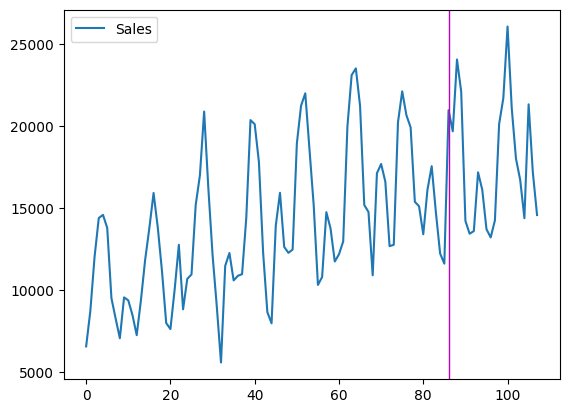

In [6]:
df.plot()
plt.axvline(n_train, c='m', lw=1.0)
plt.show()

In [7]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
data_sc = sc.fit_transform(df.values)
data_sc[:5]

array([[0.04783011],
       [0.15391359],
       [0.31454873],
       [0.42993522],
       [0.43928693]])

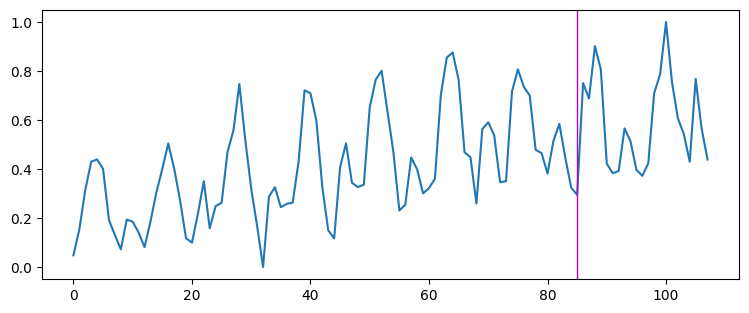

In [8]:
plt.figure(figsize=(9,3.5))
plt.plot(data_sc)
plt.axvline(n_train-1, c='m', lw=1.0)
plt.show()

In [9]:
# convert into dataset matrix
def convertToMatrix(data, step=1): 
    X, Y = [], []
    for i in range(len(data)-step):
        d = i + step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

In [10]:
train, test = data_sc[0:n_train], data_sc[n_train:]
train.shape, test.shape


((86, 1), (22, 1))

In [11]:
step = 1  #  

X_train, y_train = convertToMatrix(train, step)  
X_test, y_test = convertToMatrix(test, step)

print('Train Test (after conversion):', X_train.shape, X_test.shape)

Train Test (after conversion): (85, 1, 1) (21, 1, 1)


In [12]:
print(X_train[:5])

[[[0.04783011]]

 [[0.15391359]]

 [[0.31454873]]

 [[0.42993522]]

 [[0.43928693]]]


In [13]:
print(y_train[:7])

[[0.15391359]
 [0.31454873]
 [0.42993522]
 [0.43928693]
 [0.40051629]
 [0.19141786]
 [0.13068043]]


In [14]:

y_train.shape, y_test.shape

((85, 1), (21, 1))

## Model

In [15]:
from tensorflow.keras.layers import GRU

model = Sequential()

model.add(GRU(units=32, input_shape=(step, 1), activation="relu"))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam') 

model.summary()

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 32)             │         3,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,393 (13.25 KB)

 Non-trainable params: 0 (0.00 B)

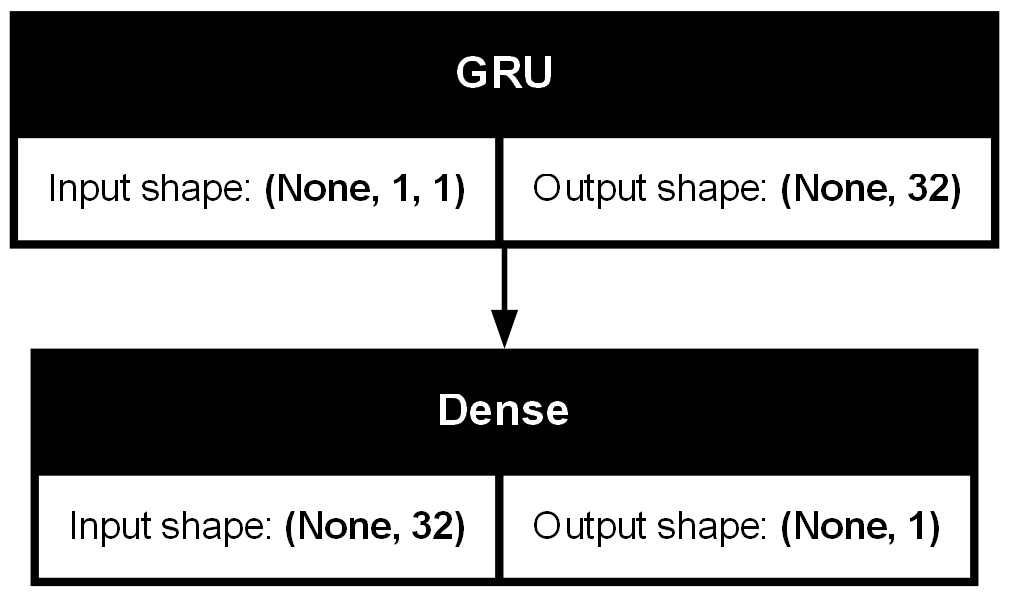

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model, 'model-car-sales.png', show_shapes=True, show_layer_names=False)# , show_dtype=True, 

In [17]:
history = model.fit(X_train, y_train, epochs=20, batch_size=1, verbose=0)

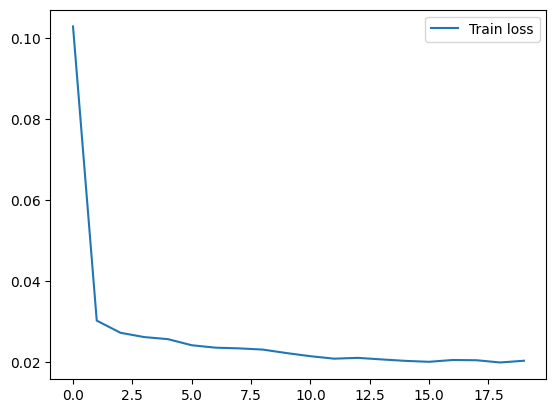

In [18]:
plt.plot(history.history['loss'], label='Train loss')
plt.legend()
plt.show()

In [19]:
score = model.evaluate(X_test, y_test, verbose=0)
print(score)

0.025901028886437416


In [20]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
trainPredict.shape, testPredict.shape

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


((85, 1), (21, 1))

In [21]:
from sklearn.metrics import mean_squared_error, r2_score

trainPredict_inv = sc.inverse_transform(trainPredict)
testPredict_inv = sc.inverse_transform(testPredict)
y_train_inv = sc.inverse_transform(y_train)
y_test_inv = sc.inverse_transform(y_test)

r2_train = r2_score(y_train_inv, trainPredict_inv)
r2_test = r2_score(y_test_inv, testPredict_inv) #

rmse_train = np.sqrt(mean_squared_error(y_train_inv, trainPredict_inv))
rmse_test = np.sqrt(mean_squared_error(y_test_inv, testPredict_inv))

print('R2 Train: {:.3f}'. format(r2_train))
print('R2 Test: {:.3f}'. format(r2_test))

print('RMSE Train: {:.3f}'. format(rmse_train))
print('RMSE Test: {:.3f}'. format(rmse_test))

R2 Train: 0.537
R2 Test: 0.239
RMSE Train: 2881.718
RMSE Test: 3304.218


In [22]:

prefix = np.empty(step).reshape(-1, 1)
prefix.fill(np.nan)

trainPredict_inv = np.concatenate((prefix, trainPredict_inv), axis=0) 
testPredict_inv = np.concatenate((prefix, testPredict_inv), axis=0) 

predict_inv = np.concatenate((trainPredict_inv,testPredict_inv),axis=0)

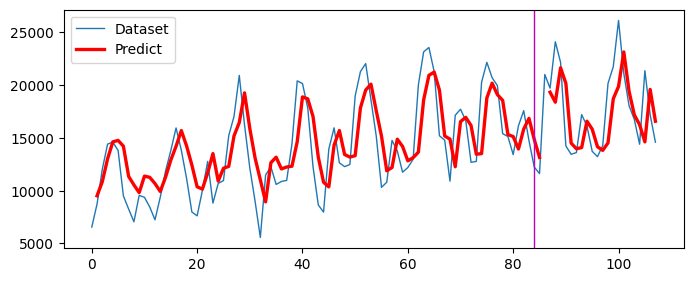

In [23]:
plt.figure(figsize=(8,3.1))
plt.plot(df.values, lw=1.0, label='Dataset')

plt.plot(predict_inv,'r', lw=2.4, label='Predict')
plt.axvline(n_train-step-1, c='m', lw=1.0)
plt.legend()
plt.show()

### Predict

In [24]:
X_input = X_train[-step:]

print(X_input)
X_input.shape

[[[0.32424139]]]


(1, 1, 1)

In [25]:
pred = model.predict(X_input)
print(pred.shape)
print(pred)
pred_inv = sc.inverse_transform(pred)

print('Prediction:', pred_inv[-1][-1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
(1, 1)
[[0.36882812]]
Prediction: 13140.41


In [26]:
X_train.shape

(85, 1, 1)

In [27]:
end = X_train.shape[0] + 1
n_back = 6
avg_cal = df[end-n_back-1:end-1].sum() / df[end-n_back-1:end-1].count()
avg_cal = avg_cal.values[0]
print('Estimate the Average: ', avg_cal.round(2))

Estimate the Average:  14859.33


In [28]:
y_true = y_train[-1].reshape(-1,1)
y_true = sc.inverse_transform(y_true)
y_true = np.squeeze(y_true)
print('Actual:', y_true)

Actual: 11608.0


86


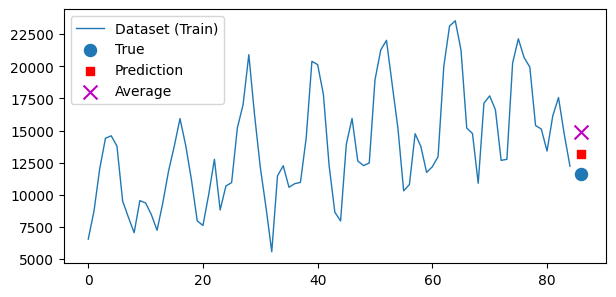

In [29]:
h_axis = X_train.shape[0] + 1  #+ step -1
print(h_axis)

train_inv = sc.inverse_transform(train)

plt.figure(figsize=(8-1,3.3))
plt.plot(df[:n_train-step], lw=1.0, label='Dataset (Train)')

plt.scatter(h_axis, y_true, s=75, label='True')
plt.scatter(h_axis, pred_inv[-1], c='r' , marker='s', s=40, label='Prediction')
plt.scatter(h_axis, avg_cal, c='m' , marker='x', s=100, label='Average')

plt.legend()
plt.show()

In [33]:
df[end-5:end+5]

,Sales
81,16135
82,17562
83,14720
84,12225
85,11608
86,20985
87,19692
88,24081
89,22114
90,14220


In [34]:

h_axis = df.shape[0] + step -1
print(h_axis)

X_new = X_test[-step:]
X_new.shape

pred = model.predict(X_new)
pred_inv = sc.inverse_transform(pred)
print('Prediction:', pred_inv[-1][-1])

108
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Prediction: 16558.494


In [35]:
X_new_inv = sc.inverse_transform(X_new.reshape(-1,1))
print('X new input:', np.squeeze(X_new_inv))

X new input: 17180.0


In [37]:
n_back = 6
avg_cal = df[- n_back:].sum() / n_back
avg_cal = avg_cal.values[0]
print('Estimate the Average: ', avg_cal.round(2))

Estimate the Average:  17038.33


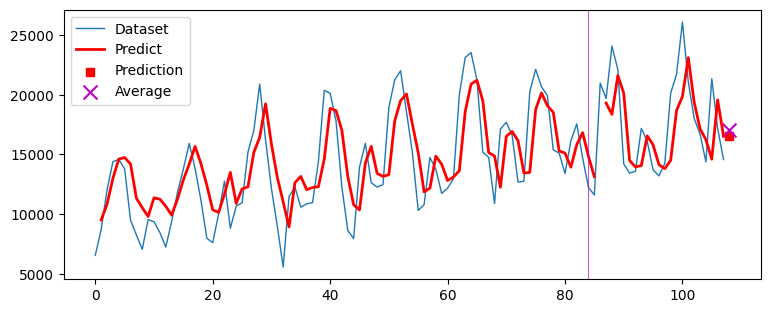

In [38]:
plt.figure(figsize=(9,3.5))

plt.plot(df, lw=1.0, label='Dataset')
# plt.plot(predict_inv,'g--', label='Pred')
plt.plot(predict_inv,'r-',lw=2.0, label='Predict')
plt.scatter(h_axis, pred_inv[-1], c='r' , marker='s', s=40, label='Prediction')
plt.scatter(h_axis, avg_cal, c='m' , marker='x', s=100, label='Average')
plt.axvline(n_train-step-1, c='m', lw=.5)
plt.legend()
plt.show()

# plt.plot(pred_inv)
plt.show()


### Poly

In [39]:
X = df.index.values.reshape(-1,1)
y = df.values     

In [40]:
X[:5]
X.shape

(108, 1)

In [41]:
y[:5]
y.shape

(108, 1)

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2)
x_poly = poly_features.fit_transform(X)

model_poly = LinearRegression()
model_poly.fit(x_poly, y)

LinearRegression()

86


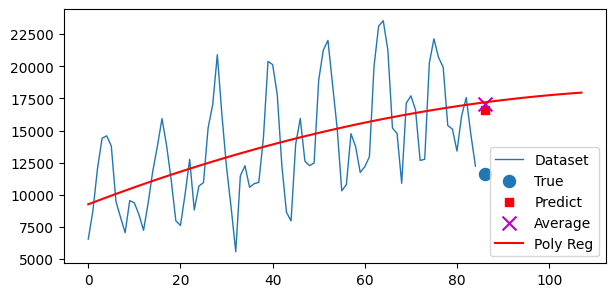

In [43]:
h_axis = X_train.shape[0] + 1 
print(h_axis)

y_poly_pred = model_poly.predict(x_poly)

train_inv = sc.inverse_transform(train)

plt.figure(figsize=(8-1,3.3))
plt.plot(df[:n_train-step], lw=1.0, label='Dataset')

plt.scatter(h_axis, y_true, s=75, label='True')
plt.scatter(h_axis, pred_inv[-1], c='r' , marker='s', s=40, label='Predict')
plt.scatter(h_axis, avg_cal, c='m' , marker='x', s=100, label='Average')

plt.plot(X, y_poly_pred, lw=1.5, color='r', label='Poly Reg')  

plt.legend(loc=4)

plt.show()

In [44]:

x_input = [[141]]
x_input = [[109]]  
y_poly_pred2 = model_poly.predict(poly_features.fit_transform(x_input))
y_poly_pred2 = np.squeeze(y_poly_pred2)
print('Prediction', y_poly_pred2.round(3))



Prediction 17995.102


In [45]:
print('Actual data:', y_true)
print('LSTM Prediction:', pred_inv[-1][-1].round(2))
print('Poly Prediction:', y_poly_pred2.round(2))
print('Averge Prediction:', avg_cal.round(2))

Actual data: 11608.0
LSTM Prediction: 16558.49
Poly Prediction: 17995.1
Averge Prediction: 17038.33
